In [22]:
!pip install  matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/27/75/de5b9cd67648051cae40039da0c8cbc497a0d99acb1a1f3d087cd66d27b7/matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/6e/be/524e377567defac0e21a46e2a529652d165fed130a0d8a863219303cee18/contourpy-1.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/db/2b/5779cfd48625e013c2dfcf0c246474d5b1f5d061a5f1e476037bf9fff3a3/fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
    

In [2]:
import torch
import torchvision
from torchinfo import summary
import tqdm

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from src import data_setup, engine

/workspaces/book_cover_classification_model/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "book_covers_dataset"

In [6]:

train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir

PosixPath('data/book_covers_dataset/train')

In [8]:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32) 

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x77a10ca85d60>,
 ['book_A', 'book_B', 'book_C'])

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/codespace/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 228MB/s]


In [12]:
model2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [13]:

summary(model=model2, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [14]:

for param in model.features.parameters():
    param.requires_grad = False

In [15]:
len(class_names)

3

In [16]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [17]:

summary(model, 
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [18]:
from torch import nn

In [19]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer 
start_time = timer()


results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:02<00:55,  2.91s/it]

Epoch: 1 | train_loss: 1.1055 | train_acc: 0.4545 | test_loss: 0.9331 | test_acc: 0.6667


 10%|█         | 2/20 [00:05<00:49,  2.74s/it]

Epoch: 2 | train_loss: 1.0011 | train_acc: 0.5455 | test_loss: 0.8525 | test_acc: 0.8333


 15%|█▌        | 3/20 [00:08<00:46,  2.75s/it]

Epoch: 3 | train_loss: 0.8392 | train_acc: 0.9545 | test_loss: 0.7741 | test_acc: 0.8333


 20%|██        | 4/20 [00:10<00:43,  2.72s/it]

Epoch: 4 | train_loss: 0.7390 | train_acc: 1.0000 | test_loss: 0.7023 | test_acc: 0.8333


 25%|██▌       | 5/20 [00:13<00:40,  2.70s/it]

Epoch: 5 | train_loss: 0.6545 | train_acc: 1.0000 | test_loss: 0.6321 | test_acc: 1.0000


 30%|███       | 6/20 [00:16<00:38,  2.77s/it]

Epoch: 6 | train_loss: 0.5656 | train_acc: 1.0000 | test_loss: 0.5670 | test_acc: 1.0000


 35%|███▌      | 7/20 [00:19<00:35,  2.76s/it]

Epoch: 7 | train_loss: 0.4766 | train_acc: 1.0000 | test_loss: 0.5075 | test_acc: 1.0000


 40%|████      | 8/20 [00:22<00:33,  2.80s/it]

Epoch: 8 | train_loss: 0.3941 | train_acc: 1.0000 | test_loss: 0.4520 | test_acc: 1.0000


 45%|████▌     | 9/20 [00:24<00:30,  2.80s/it]

Epoch: 9 | train_loss: 0.3516 | train_acc: 1.0000 | test_loss: 0.4020 | test_acc: 1.0000


 50%|█████     | 10/20 [00:27<00:28,  2.84s/it]

Epoch: 10 | train_loss: 0.2800 | train_acc: 1.0000 | test_loss: 0.3573 | test_acc: 1.0000


 55%|█████▌    | 11/20 [00:30<00:25,  2.83s/it]

Epoch: 11 | train_loss: 0.2754 | train_acc: 1.0000 | test_loss: 0.3159 | test_acc: 1.0000


 60%|██████    | 12/20 [00:33<00:22,  2.76s/it]

Epoch: 12 | train_loss: 0.2202 | train_acc: 1.0000 | test_loss: 0.2786 | test_acc: 1.0000


 65%|██████▌   | 13/20 [00:36<00:19,  2.77s/it]

Epoch: 13 | train_loss: 0.1936 | train_acc: 1.0000 | test_loss: 0.2479 | test_acc: 1.0000


 70%|███████   | 14/20 [00:38<00:16,  2.74s/it]

Epoch: 14 | train_loss: 0.1545 | train_acc: 1.0000 | test_loss: 0.2213 | test_acc: 1.0000


 75%|███████▌  | 15/20 [00:41<00:13,  2.76s/it]

Epoch: 15 | train_loss: 0.1452 | train_acc: 1.0000 | test_loss: 0.2009 | test_acc: 1.0000


 80%|████████  | 16/20 [00:44<00:10,  2.68s/it]

Epoch: 16 | train_loss: 0.1586 | train_acc: 1.0000 | test_loss: 0.1842 | test_acc: 1.0000


 85%|████████▌ | 17/20 [00:46<00:08,  2.70s/it]

Epoch: 17 | train_loss: 0.1058 | train_acc: 1.0000 | test_loss: 0.1697 | test_acc: 1.0000


 90%|█████████ | 18/20 [00:49<00:05,  2.65s/it]

Epoch: 18 | train_loss: 0.1248 | train_acc: 1.0000 | test_loss: 0.1589 | test_acc: 1.0000


 95%|█████████▌| 19/20 [00:52<00:02,  2.67s/it]

Epoch: 19 | train_loss: 0.0994 | train_acc: 1.0000 | test_loss: 0.1486 | test_acc: 1.0000


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

Epoch: 20 | train_loss: 0.0809 | train_acc: 1.0000 | test_loss: 0.1415 | test_acc: 1.0000
[INFO] Total training time: 54.711 seconds


In [23]:
from typing import List, Tuple
import matplotlib.pyplot as plt

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = auto_transforms,
                        device: torch.device=device):
    
    

    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = auto_transforms

    ### Predict on image ### 


    model.to(device)

    model.eval()
    with torch.inference_mode():

      transformed_image = image_transform(img).unsqueeze(dim=0)


      target_image_pred = model(transformed_image.to(device))


    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)


    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)



    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);



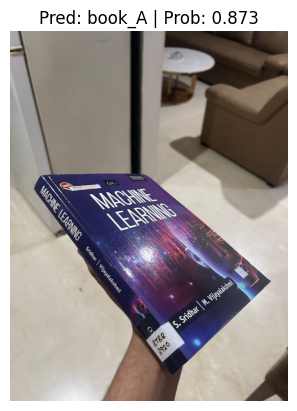

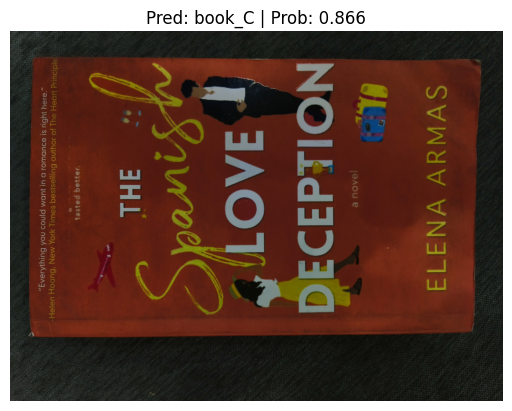

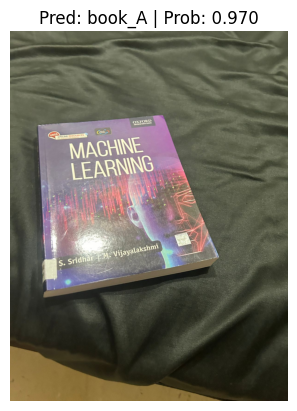

In [24]:

import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot)


for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [29]:
custom_image_path = Path('./predictions/prediction.jpg')

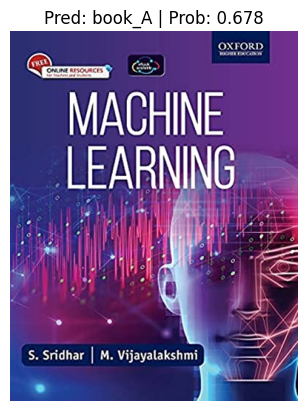

In [30]:
pred_and_plot_image(model = model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224,224))

In [33]:
def predicted_books(model, auto_transforms, custom_image_path):

    image = Image.open(custom_image_path)


    transformed_image = auto_transforms(image)

    transformed_image = transformed_image.unsqueeze(0)


    with torch.no_grad():
        model.eval()
        predictions = model(transformed_image)

    _, predicted_idx = torch.max(predictions, 1)
    predicted_label = class_names[predicted_idx.item()]

    return predicted_label


In [34]:
predicted_books(model, auto_transforms, custom_image_path)

'book_A'

In [35]:
torch.save(model.state_dict(), "models/model.pth")

# now using the saved model

In [36]:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [37]:
model_base = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [39]:

for param in model_base.features.parameters():
    param.requires_grad = False

In [40]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)


model_base.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [41]:

model2 = model_base
model2.load_state_dict(torch.load("models/model.pth"))
model2.eval()

/tmp/ipykernel_16657/3664887404.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("models/model.pth"))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
predicted_books(model2, auto_transforms, custom_image_path)

'book_A'